In [1]:
!pip install onboard.client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 KB 6.1 MB/s eta 0:00:00
  Attempting uninstall: orjson
    Found existing installation: orjson 3.6.7
    Uninstalling orjson-3.6.7:
      Successfully uninstalled orjson-3.6.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.37.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.37.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.4 which is incompatible.
apache-beam 2.37.0 requires pyarrow<7.0.0,>=0.15.1, but you have pyarrow 7.0.0 which is incompatible.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# RTEM APIs
import requests
import pytz
from onboard.client import RtemClient
from onboard.client.models import TimeseriesQuery, PointData, PointSelector
from onboard.client.dataframes import points_df_from_streaming_timeseries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

from IPython.display import display

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/multifamily/multifamily.csv
/kaggle/input/multifamily/multifamily-2.csv
/kaggle/input/multifamily/multifamily-4.csv
/kaggle/input/multifamily/multifamily-3.csv
/kaggle/input/rtem-preprocessed/metadata_44342.csv
/kaggle/input/rtem-preprocessed/metadata_44390.csv
/kaggle/input/rtem-preprocessed/metadata-2.csv


## API Data

In [3]:
client = RtemClient(api_key="...(enter your RTEM API key here)...")

In [4]:
metadata = pd.read_csv('/kaggle/input/rtem-preprocessed/metadata-2.csv')

# `Multifamily Energy Consumption Profiling`

* Smart buildings vs Regular buildings (Site EUI)
* Lighting energy consumption (Identify lighting upgrade opportunity)
* Electricity consumption (Identify inefficient equipment upgrade opportunity)
* Income level, nearby infrastructure, poepl of color vs energy consumption pattern
* lifestyle pattern vs occupancy schedule

In [5]:
multifam = pd.read_csv('/kaggle/input/multifamily/multifamily-4.csv', )

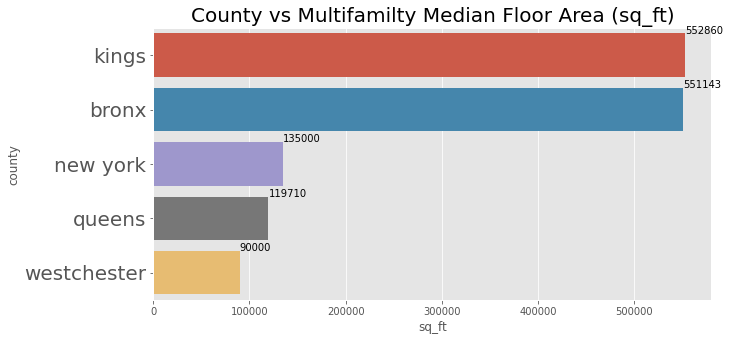

In [6]:
# largest floor area building is in new york > kings > bronx > queens > westchester
# median floor areas are the largest in kings > bronx > new york > queens > westchester
# smallest floor areas are in new york < kings < bronx < westchester < queens
multifam[['county','sq_ft','last_updated','first_updated', 'point_type']].groupby('county').median().sort_values('sq_ft', ascending=False).astype(int).style.background_gradient()
area = multifam[['county','sq_ft','last_updated','first_updated', 'point_type']].groupby('county').median().sort_values('sq_ft', ascending=False).astype(int)
area

plt.figure(figsize=(10,5))
g = sns.barplot(data=area, x='sq_ft', y=area.index)
plt.yticks(size=20)
plt.title('County vs Multifamilty Median Floor Area (sq_ft)', size=20)

for p in g.patches:
    txt = str(round(p.get_width()))
    txt_x = p.get_width()
    txt_y = p.get_y()
    g.text(txt_x, txt_y, txt)


plt.show()

In [7]:
multifam.head(1).T

,0
point_id,310029
building_id,441
last_updated,2019-06-15 04:00:00+00:00
first_updated,2019-02-19 02:01:01+00:00
point_name,245 E 149th St. Boiler-1 Fault Code
point_description,NaN
tagged_units,?
point_value,0
point_type,Virtual
point_type_id,434


## Equipment, Points Counts (#):

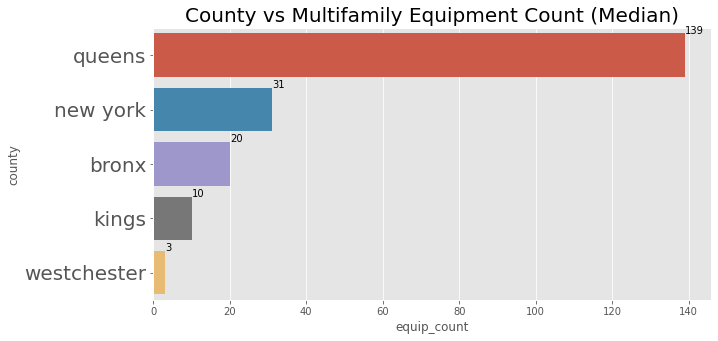

In [8]:
equip = multifam[['county','sq_ft','equip_count','point_count']].groupby('county').median().sort_values('equip_count', ascending=False).astype(int)
equip

plt.figure(figsize=(10,5))
g = sns.barplot(data=equip, x='equip_count', y=equip.index)
plt.yticks(size=20)
plt.title('County vs Multifamily Equipment Count (Median)', size=20)

for p in g.patches:
    txt = str(round(p.get_width()))
    txt_x = p.get_width()
    txt_y = p.get_y()
    g.text(txt_x, txt_y, txt)


plt.show()

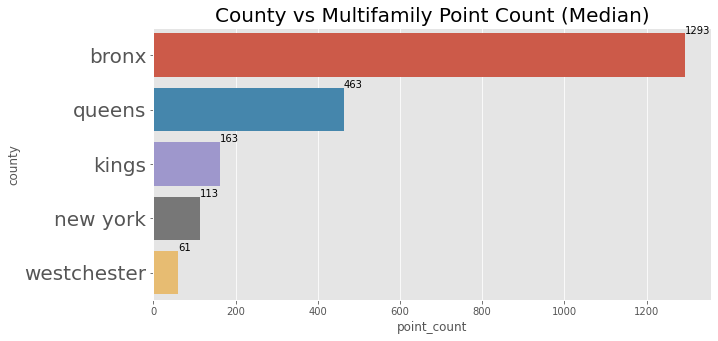

In [9]:
point = multifam[['county','sq_ft','equip_count','point_count']].groupby('county').median().sort_values('point_count', ascending=False).astype(int)
point

plt.figure(figsize=(10,5))
g = sns.barplot(data=point, x='point_count', y=point.index)
plt.yticks(size=20)
plt.title('County vs Multifamily Point Count (Median)', size=20)

for p in g.patches:
    txt = str(round(p.get_width()))
    txt_x = p.get_width()
    txt_y = p.get_y()
    g.text(txt_x, txt_y, txt)


plt.show()

## Equipment/Points Counts Insights:

* In average (median), Bronx has the moderate equipment counts (20), but has the largest points (234).
* In average (median), Queens has the most equipment counts (139) and the second largest points (463).

When compared to the floor area:
* In average (median), Queens has the most equipment / floor ratio.
* In average (median), Bronx has the second most points / floor ratio after queens.

We can compare more points buildings vs less points buildings (**`Smart Buildings vs Regular`**) 
* Queens/Bronx vs 'New York/Kings (/ WestChester)?
* Does moitoring help with increasing energy efficiency?
* Does monitoring has health benefit? (Ozone, CO2)


## Equipment, Points / Floor area Ratio (#/ft2):

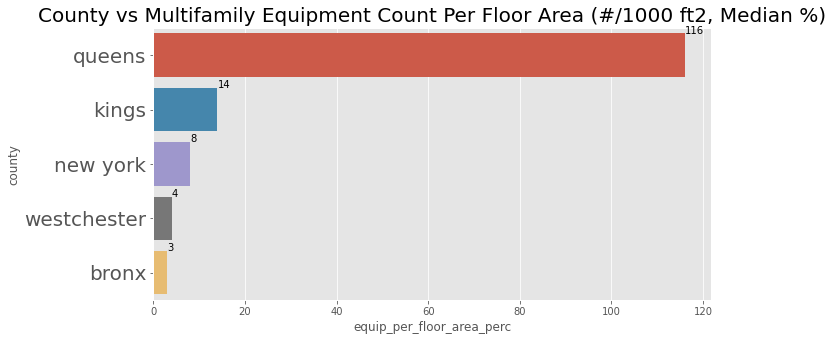

In [10]:
# equipment count per floor area
multifam['equip_per_floor_area_perc'] = multifam.equip_count / multifam.sq_ft * 100 * 1000

equip_area_ratio = multifam[['county','sq_ft','equip_count','point_count', 'equip_per_floor_area_perc']].groupby('county').median().sort_values('equip_per_floor_area_perc', ascending=False).astype(int)
equip_area_ratio

plt.figure(figsize=(10,5))
g = sns.barplot(data=equip_area_ratio, x='equip_per_floor_area_perc', y=equip_area_ratio.index)
plt.yticks(size=20)
plt.title('County vs Multifamily Equipment Count Per Floor Area (#/1000 ft2, Median %)', size=20)

for p in g.patches:
    txt = str(round(p.get_width()))
    txt_x = p.get_width()
    txt_y = p.get_y()
    g.text(txt_x, txt_y, txt)


plt.show()

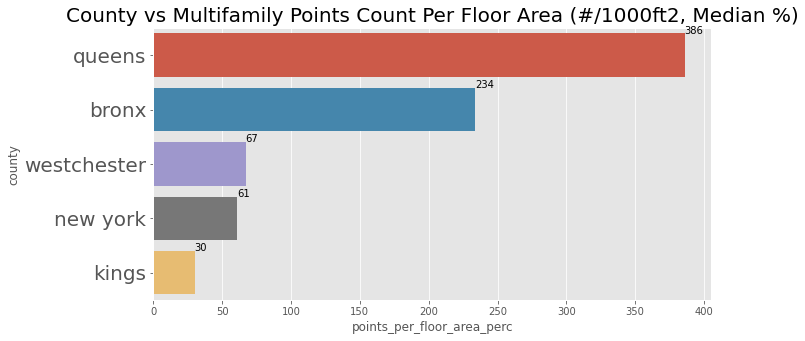

In [11]:
# equipment count per floor area
multifam['points_per_floor_area_perc'] = multifam.point_count / multifam.sq_ft * 100 * 1000

point_area_ratio = multifam[['county','sq_ft','equip_count','point_count', 'points_per_floor_area_perc']].groupby('county').median().sort_values('points_per_floor_area_perc', ascending=False).astype(int)
point_area_ratio

plt.figure(figsize=(10,5))
g = sns.barplot(data=point_area_ratio, x='points_per_floor_area_perc', y=point_area_ratio.index)
plt.yticks(size=20)
plt.title('County vs Multifamily Points Count Per Floor Area (#/1000ft2, Median %)', size=20)

for p in g.patches:
    txt = str(round(p.get_width()))
    txt_x = p.get_width()
    txt_y = p.get_y()
    g.text(txt_x, txt_y, txt)


plt.show()

# SENSOR COUNTS

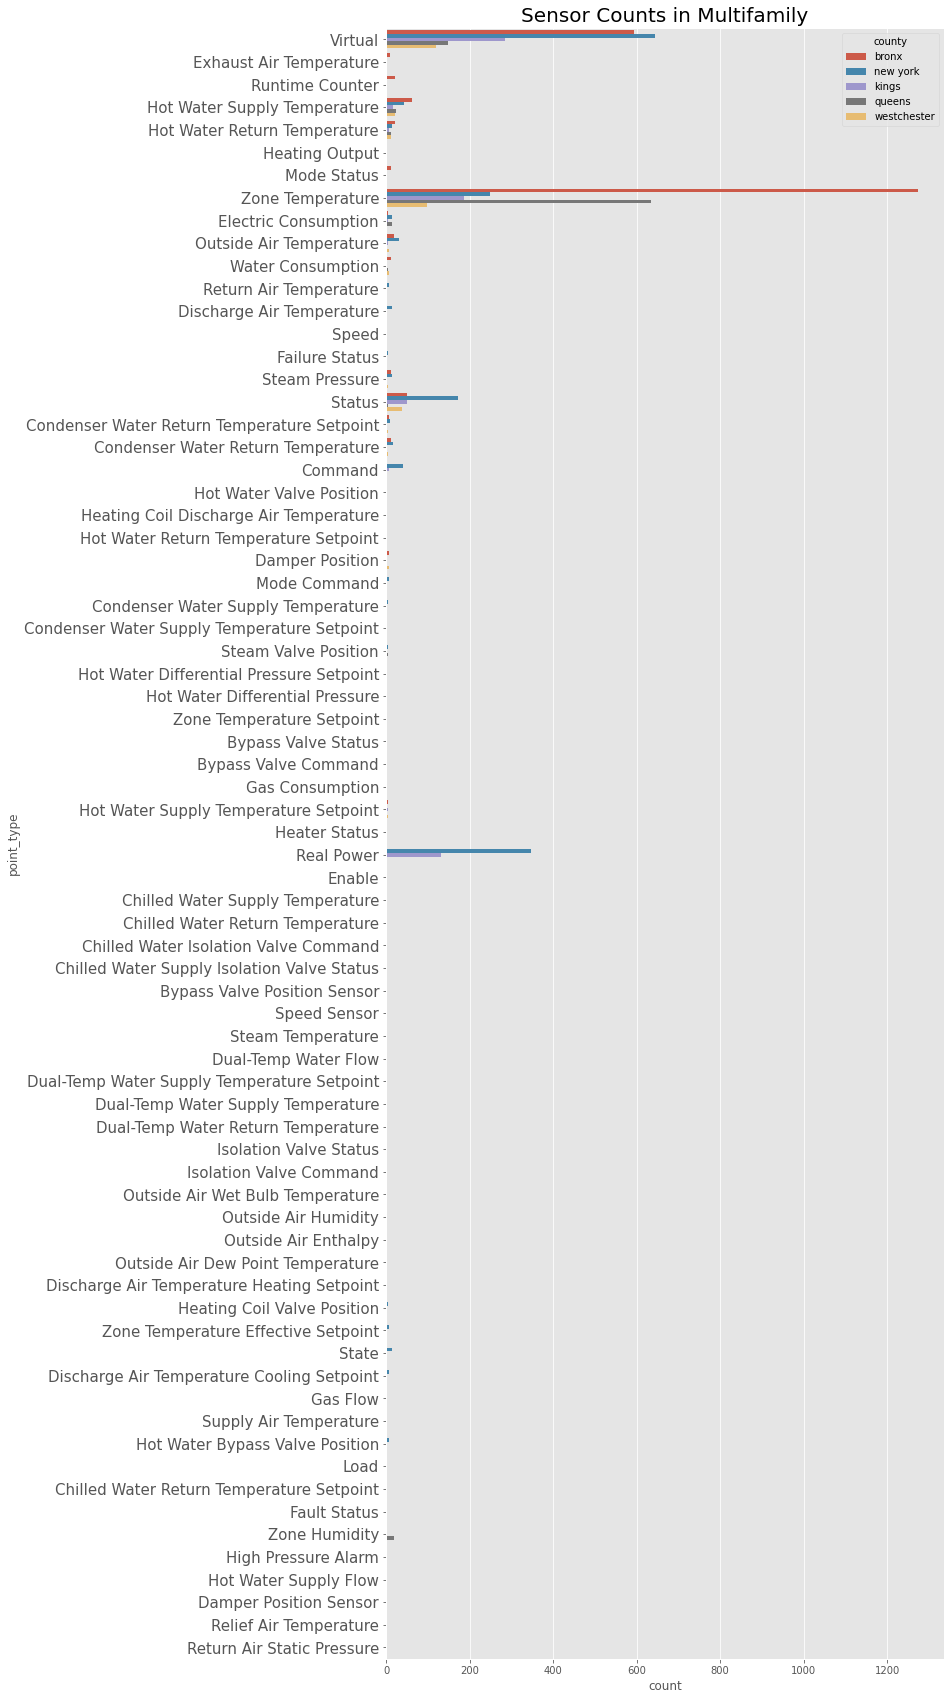

In [12]:
# zone temp > virtual sensors > real power > status
# let's look at numerical sensor values
plt.figure(figsize = (10,30))
sns.countplot(data=multifam[multifam.point_count > 0], y=multifam[multifam.point_count > 0]['point_type'], hue='county')
plt.yticks(size=15)
plt.title('Sensor Counts in Multifamily', size=20)
plt.show()

## Insights:
* **`New York County`** has exceptionally a lot of **`real power meters`**.
* **`New York / Bronx County`** has exceptionally a lot of **`virtual sensors`**
* **`Bronx / Queens County`** has exceptionally a lot of **`zone temperature sensors`**

*point_type* of Interest (Primary):
* Real Power 
* Zone Temperature 
* Outside Air Temperature
* Virtual

*point_type* of Interest (Secondary):
* Hot Water Supply Temperature
* Hot Water Return Temperature
* Electric Consumption

## Methodology:
* Zone Temperature: 
    * daily average (resample @1D, mean) -> compare between counties
    * hourly profile (resample @1H, mean) -> compare between buildings
    * hourly profile (resample @1H, mena) -> compare between counties (hourly mean of buildings)
    

* Virtual Meters:
    * further breakdown -> see list of sub sensor types
    

* Outside Air Temperature:
    * hourly profile -> compare between buidilngs, counties
    * daily profile -> compare between buildings, counties
    

# `METADATA QUERY` -- SELECTED POINTS

In [13]:
multifam.convert_dtypes().dtypes;

## Select Date Range --> [2018-2021]

In [14]:
# multifamily has about 4 years of data [2018-2021], which includes COVID before/after
print ('fist updated: ', multifam.first_updated.min())
print ('last updated: ', multifam.last_updated.max())

fist updated:  2018-02-01 05:00:00+00:00
last updated:  2021-12-31 23:45:00+00:00


In [15]:
# before vs after COVID-19
print(multifam[multifam.last_updated < '2020-04-30'].shape[0], ' sensor readings availble before COVID-19')
print(multifam[multifam.last_updated > '2020-04-30'].shape[0], ' sensor readings availble during/after COVID-19')

3365  sensor readings availble before COVID-19
2438  sensor readings availble during/after COVID-19


## 1.0 Querying points Metadata by (point_type / buildig_id)
* We aleady have this info in our **`metadata.csv`** file. We can just filter it instead.

In [16]:
# query = PointSelector()

# # QUERY BY POINT_TYPE, BUILDING_ID, EQUIP_ID
# query.point_types = ['Virtual'] # <-----INPUT
# query.buildings = ["214"]       # <-----INPUT
# query.equipment =['36558']      # <-----INPUT

# # see filtered point perperties
# selection = client.select_points(query)
# selection

# # QUERY BY POINT_ID
# points_selec = selection["points"]
# points_selec                    # <-----INPUT (automatic based above selection)
# # points_select = ['310029']    # <-----INPUT (manual)

# # query selected points info
# sensor_metadata = client.get_points_by_ids(points_selec)
# sensor_metadata = pd.DataFrame(sensor_metadata).rename(columns={'id':'point_id', 'value':'point_value','type':'point_type'})

# sensor_metadata.head(1).T

## {Equip_type_name : Equip_id} DICTIONARY

In [17]:
# Equipment Type Dictionary
multifam[['equip_id','equip_type_name']].groupby('equip_type_name').max()

,equip_id
equip_type_name,
Air Handling Unit,31710
Battery,18673
Boiler,36560
Chilled Water Plant,17337
Chiller,33264
Condenser,19779
Cooling Tower,33265
Duct Heater,17340
Electrical Panel,31775


# `SEARCH EQUIPEMNT_TYPES BY POINT_TYPE --- IN MULTIFAMILY`

In [18]:
# search list of equipments associated with 'point type'
point_type_search = 'Zone Temperature'  # <----- INPUT

ptype_df = multifam[['point_type','equip_type_name']].groupby("point_type")["equip_type_name"].agg(set).to_frame()
ptype_df[ptype_df.index == point_type_search].values.tolist()

[[{'Boiler', 'Hot Water Plant', 'Site Sensors'}]]

In [19]:
df1 = multifam

u = df1.groupby("point_type")["equip_type_name"].agg(set)
df1["equip_list"] = df1["point_type"].map(u[u.str.len().ge(2)])
df1.head(1).T

,0
point_id,310029
building_id,441
last_updated,2019-06-15 04:00:00+00:00
first_updated,2019-02-19 02:01:01+00:00
point_name,245 E 149th St. Boiler-1 Fault Code
point_description,NaN
tagged_units,?
point_value,0
point_type,Virtual
point_type_id,434


In [20]:
multifam[multifam.point_type == 'Zone Temperature']

,point_id,building_id,last_updated,first_updated,point_name,point_description,tagged_units,point_value,point_type,point_type_id,...,sq_ft,borough,building_type,equip_type_abbr,equip_type_name,equip_tags,county,equip_per_floor_area_perc,points_per_floor_area_perc,equip_list
262,310640,441,2019-06-14 04:05:00+00:00,2019-01-25 16:15:00+00:00,225 E 149th St. Floor-20 Apartment-G APT 20G T...,NaN,f,74.63,Zone Temperature,77,...,551143.0,bronx,Multifamily,SITE,Site Sensors,['site'],bronx,3.628822,234.603361,"{Boiler, Hot Water Plant, Site Sensors}"
263,310287,441,2019-06-14 04:05:00+00:00,2019-01-24 18:30:00+00:00,225 E 149th St. Floor-03 Apartment-M APT 03M T...,NaN,f,75.76,Zone Temperature,77,...,551143.0,bronx,Multifamily,SITE,Site Sensors,['site'],bronx,3.628822,234.603361,"{Boiler, Hot Water Plant, Site Sensors}"
264,310350,441,2019-06-14 04:05:00+00:00,2019-01-24 19:00:00+00:00,225 E 149th St. Floor-05 Apartment-J APT 05J T...,NaN,f,77.33,Zone Temperature,77,...,551143.0,bronx,Multifamily,SITE,Site Sensors,['site'],bronx,3.628822,234.603361,"{Boiler, Hot Water Plant, Site Sensors}"
265,310397,441,2021-01-01 04:45:00+00:00,2019-07-01 04:00:00+00:00,225 E 149th St. Floor-06 Apt-06E Zone Zone Tem...,NaN,f,74.26,Zone Temperature,77,...,551143.0,bronx,Multifamily,SITE,Site Sensors,['site'],bronx,3.628822,234.603361,"{Boiler, Hot Water Plant, Site Sensors}"
266,310426,441,2021-01-01 04:45:00+00:00,2019-07-01 04:00:00+00:00,225 E 149th St. Floor-07 Apt-07A Zone Zone Tem...,NaN,f,79.32,Zone Temperature,77,...,551143.0,bronx,Multifamily,SITE,Site Sensors,['site'],bronx,3.628822,234.603361,"{Boiler, Hot Water Plant, Site Sensors}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5798,204988,214,2020-01-01 04:45:00+00:00,2019-06-06 14:15:00+00:00,151 E 43rd Street Apt 16 temp,151 E 43rd Street Apt 16 temp,f,77.09,Zone Temperature,77,...,12000.0,manhattan,Multifamily,SITE,Site Sensors,['site'],new york,33.333333,600.000000,"{Boiler, Hot Water Plant, Site Sensors}"
5799,204987,214,2020-01-01 04:45:00+00:00,2019-06-01 04:00:00+00:00,151 E 43rd Street Apt 15 temp,151 E 43rd Street Apt 15 temp,f,74.19,Zone Temperature,77,...,12000.0,manhattan,Multifamily,SITE,Site Sensors,['site'],new york,33.333333,600.000000,"{Boiler, Hot Water Plant, Site Sensors}"
5800,204986,214,2020-01-01 04:45:00+00:00,2019-06-06 14:15:00+00:00,151 E 43rd Street Apt 14 temp,151 E 43rd Street Apt 14 temp,f,75.19,Zone Temperature,77,...,12000.0,manhattan,Multifamily,SITE,Site Sensors,['site'],new york,33.333333,600.000000,"{Boiler, Hot Water Plant, Site Sensors}"
5801,204985,214,2020-01-01 04:45:00+00:00,2019-06-06 14:15:00+00:00,151 E 43rd Street Apt 13 temp,151 E 43rd Street Apt 13 temp,f,73.40,Zone Temperature,77,...,12000.0,manhattan,Multifamily,SITE,Site Sensors,['site'],new york,33.333333,600.000000,"{Boiler, Hot Water Plant, Site Sensors}"


In [21]:
multifam[['point_value','tagged_units','point_id','point_type','equip_id','equip_type_name']]

,point_value,tagged_units,point_id,point_type,equip_id,equip_type_name
0,0,?,310029,Virtual,28797,Boiler
1,183.55,f,310009,Exhaust Air Temperature,28797,Boiler
2,0,?,310010,Virtual,28797,Boiler
3,46.90,?,310011,Virtual,28797,Boiler
4,91,?,310012,Virtual,28797,Boiler
...,...,...,...,...,...,...
5798,77.09,f,204988,Zone Temperature,36558,Site Sensors
5799,74.19,f,204987,Zone Temperature,36558,Site Sensors
5800,75.19,f,204986,Zone Temperature,36558,Site Sensors
5801,73.40,f,204985,Zone Temperature,36558,Site Sensors


In [22]:
multifam.equip_id.nunique()

947

In [23]:
multifam.describe(include='all').T;

# `TIME SERIES QEURY` -- MULTIFAMILY

## 1.1 Select Points --> Outside Air Temperature

In [24]:
# SELECT TIME
# __________________________________________________
# filter time range for point data extraction
# Select your timezone
tz = pytz.timezone('UTC')
# Select your date and time (time is optional)
start = datetime(2021,1,1,0,0,0).replace(tzinfo=tz)
end = datetime(2022,1,1,0,0,0).replace(tzinfo=tz)



# SELECT POINTS
# __________________________________________________

outside_temp = multifam[(multifam.point_type == 'Outside Air Temperature') & (multifam.county == 'bronx')]['point_id'].unique().tolist()
points = outside_temp
print(f"Outside Air Points extracting from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}: \n")
print(np.array(points))


# __________________________________________________

# print(datetime.today()) #.strftime('%Y-%m-%d'))
print('\n query start time: ', datetime.today())

# Ask for points within a time range
timeseries_query = TimeseriesQuery(point_ids = points, start = start, end = end)
# Exceute query (will return and object)
query_results = client.stream_point_timeseries(timeseries_query)
# Convert to dataframe
data = points_df_from_streaming_timeseries(query_results)
# query results
data.to_csv("/kaggle/working/rtem_2021_bronx_outside_air_temp_time_series.csv", index=False)
print(' query end time: ', datetime.today())

Outside Air Points extracting from 2021-01-01 to 2022-01-01: 

[310273 310902 310903 284547 227356 197859 344462 199158 197203 198109
 197400 198660 203588 201571 414653 205063 205613 215190 221324]

 query start time:  2022-05-21 02:00:26.736699
 query end time:  2022-05-21 02:00:27.160137


## 1.2 Select Points --> Zone Temperature

In [25]:
# SELECT TIME
# __________________________________________________
# filter time range for point data extraction
# Select your timezone
tz = pytz.timezone('UTC')
# Select your date and time (time is optional)
start = datetime(2021,1,1,0,0,0).replace(tzinfo=tz)
end = datetime(2022,1,1,0,0,0).replace(tzinfo=tz)



# SELECT POINTS
# __________________________________________________

zone_temp = multifam[(multifam.point_type == 'Zone Temperature') & (multifam.county == 'westchester')]['point_id'].unique().tolist()
points = zone_temp
print(f"Zone Temperature Points extracting from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}: \n")
print(np.array(points))

# __________________________________________________

# print(datetime.today()) #.strftime('%Y-%m-%d'))
print('\n query start time: ', datetime.today())

# Ask for points within a time range
timeseries_query = TimeseriesQuery(point_ids = points, start = start, end = end)
# Exceute query (will return and object)
query_results = client.stream_point_timeseries(timeseries_query)
# Convert to dataframe
data = points_df_from_streaming_timeseries(query_results)
# query results
data.to_csv("/kaggle/working/rtem_2021_westchester_zone_temp_time_series.csv", index=False)
print(' query end time: ', datetime.today())

Zone Temperature Points extracting from 2021-01-01 to 2022-01-01: 

[356103 356148 356147 356146 356145 356144 356143 356142 387458 387457
 387456 387455 387454 387453 387452 387451 387450 387449 206321 206320
 206319 206318 206317 206316 206315 206314 206313 206312 210740 210739
 210738 210737 210736 210735 210734 210733 210732 210731 210730 210729
 210728 210727 210726 210725 210724 210723 210722 210721 210720 210719
 210718 210717 210716 210715 210714 210713 210712 210711 210710 210709
 210708 210707 210706 210705 221803 221801 221790 221794 221784 221788
 221798 221791 221787 221785 221793 221796 221792 221800 221797 221795
 221786 221789 221802 221799 224485 224495 224492 224488 224497 224490
 224493 224496 224499 224491 224487 224494 224486 224489 224498]

 query start time:  2022-05-21 02:00:27.520296
 query end time:  2022-05-21 02:00:28.135832


## 1.3 Select Points --> Real Power

In [26]:
# SELECT TIME
# __________________________________________________
# filter time range for point data extraction
# Select your timezone
tz = pytz.timezone('UTC')

# Select your date and time (time is optional)
start = datetime(2021,1,1,0,0,0).replace(tzinfo=tz)
end = datetime(2022,1,1,0,0,0).replace(tzinfo=tz)



# SELECT POINTS
# __________________________________________________

real_power = multifam[(multifam.point_type == 'Real Power') & (multifam.county == 'new york')]['point_id'].unique().tolist()
points = real_power
print(f"Real Power Points extracting from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}: \n")


print(np.array(points))

# __________________________________________________

# print(datetime.today()) #.strftime('%Y-%m-%d'))
print('\n query start time: ', datetime.today())

# Ask for points within a time range
timeseries_query = TimeseriesQuery(point_ids = points, start = start, end = end)

# Exceute query (will return and object)
query_results = client.stream_point_timeseries(timeseries_query)

# Convert to dataframe
data = points_df_from_streaming_timeseries(query_results)

# query results
data.to_csv("/kaggle/working/rtem_2021_new_york_real_power_time_series.csv", index=False)
print(' query end time: ', datetime.today())

Real Power Points extracting from 2021-01-01 to 2022-01-01: 

[206164 206165 206166 206167 206168 206169 206170 206171 206172 206173
 206174 206175 206176 206177 206178 206179 206180 206181 206182 206183
 206184 206185 206186 206187 206188 206189 206190 206191 206192 206193
 206194 206195 206196 206197 206198 206199 206200 206201 206202 206203
 206204 206205 206206 206207 206208 206209 206210 206211 206212 206213
 206214 206215 206216 206217 206218 206219 206220 206221 206222 206223
 206224 206226 206225 206227 206228 206229 206230 206232 206231 206233
 206237 206238 206239 206240 206241 206242 206243 206244 206245 206246
 206247 206248 206249 206250 206251 206253 206252 206254 206255 206256
 206257 206258 206259 206260 358160 358162 386656 208804 208802 208803
 208801 208799 208795 208794 208793 208791 208797 208790 208787 208786
 208785 208784 208792 208800 208798 208796 208789 208788 208783 208782
 208893 208894 208895 208896 208897 208898 208899 208900 208901 208902
 208903 208904 

## 1.4 Select Points --> Virtual

In [27]:
# SELECT TIME
# __________________________________________________
# filter time range for point data extraction
# Select your timezone
tz = pytz.timezone('UTC')
# Select your date and time (time is optional)
start = datetime(2021,1,1,0,0,0).replace(tzinfo=tz)
end = datetime(2022,1,1,0,0,0).replace(tzinfo=tz)



# SELECT POINTS
# __________________________________________________

outside_temp = multifam[(multifam.point_type == 'Virtual') & (multifam.county == 'new york')]['point_id'].unique().tolist()
points = outside_temp
print(f"Virtual Points extracting from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}: \n")
print(np.array(points))


# __________________________________________________

# print(datetime.today()) #.strftime('%Y-%m-%d'))
print('\n query start time: ', datetime.today())

# Ask for points within a time range
timeseries_query = TimeseriesQuery(point_ids = points, start = start, end = end)
# Exceute query (will return and object)
query_results = client.stream_point_timeseries(timeseries_query)
# Convert to dataframe
data = points_df_from_streaming_timeseries(query_results)
# query results
data.to_csv("/kaggle/working/rtem_2021_new_york_virtual_time_series.csv", index=False)
print(' query end time: ', datetime.today())

Virtual Points extracting from 2021-01-01 to 2022-01-01: 

[208332 208328 208336 208334 208326 208327 208331 208329 208335 208333
 208330 208342 208341 208340 208339 208346 208345 208344 208343 208348
 208347 414656 217172 217171 217170 217169 217168 217167 217166 217165
 217164 217163 217162 217161 217160 326012 326005 326004 326022 326020
 326019 326016 326015 326011 326008 326000 325999 326034 326033 206084
 206122 206075 206078 206089 206090 206091 206093 206095 206102 206105
 206108 206115 206118 206125 206128 206129 206130 206131 206134 206133
 206135 206137 206139 206140 206141 206146 206147 206148 206149 206150
 206151 206152 206153 206154 206160 206158 206161 206162 206163 206085
 206077 206086 206082 206121 206106 206143 206142 206138 206136 206116
 206119 206114 206113 206112 206081 206080 206079 206156 206157 206159
 206155 206120 206126 206123 206145 206127 206124 206132 206144 206117
 206111 206110 206109 206107 206100 206104 206098 206099 206092 206096
 206097 206094 206

In [28]:
point_type = pd.DataFrame(client.get_all_point_types())
point_type.to_csv('/kaggle/working/onboard.csv')

In [30]:
tag = pd.DataFrame(client.get_tags())
tag.to_csv('/kaggle/working/haystack.csv')